### Imports

In [2]:
import warnings
warnings.simplefilter("ignore")

from sktime.forecasting.compose import RecursiveTimeSeriesRegressionForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.utils.plotting import plot_series
from datetime import timedelta
from datetime import datetime
import pandas as pd
import numpy as np

### Leitura do dataset, formatação dele

In [25]:
df = pd.read_csv("../data/pessoas_ocupadas_2020-2023.csv")
df = df.T
df = df.rename(columns={0:"populacao"})
df.index = pd.to_datetime(df.index)
df.index = df.index.to_period("M")
df.populacao = pd.to_numeric(df.populacao)
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 48 entries, 2020-01 to 2023-12
Freq: M
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   populacao  48 non-null     int64
dtypes: int64(1)
memory usage: 768.0 bytes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2012-01 to 2019-12
Freq: M
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   populacao  96 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


<Axes: >

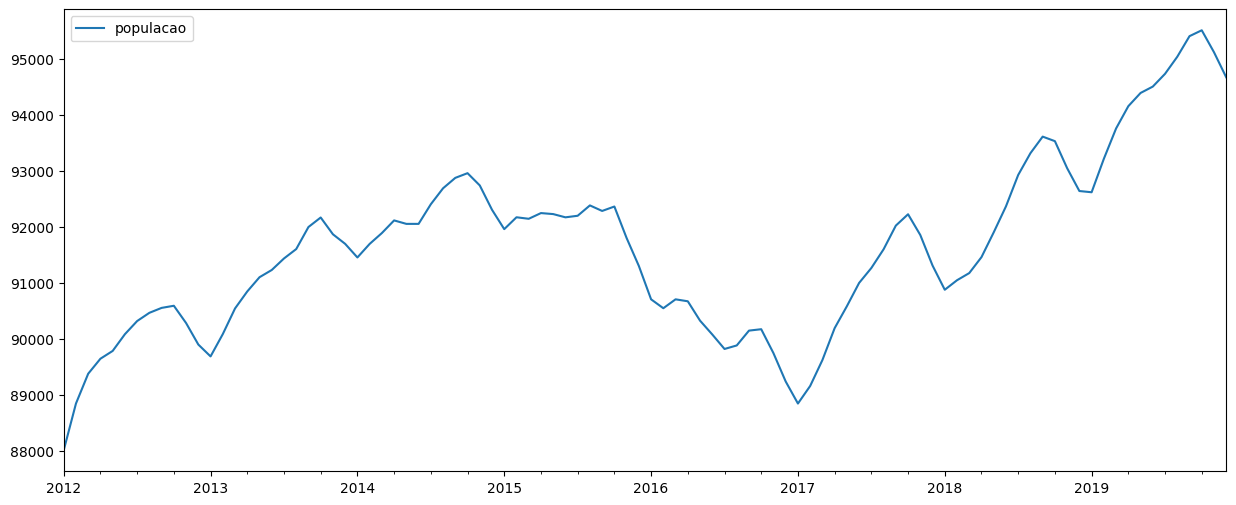

In [6]:
df.plot(figsize=(15,6))

## Separação treino e teste

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

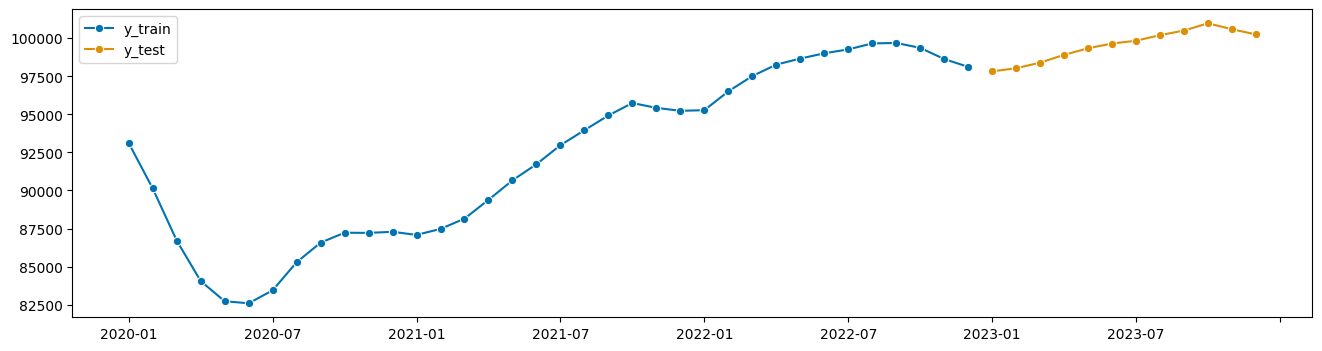

In [33]:
y = df
y_train, y_test = temporal_train_test_split(y)
fh = np.arange(len(y_test))+1
plot_series(y_train, y_test, labels=["y_train", "y_test"])

## Previsões com o método Forecaster 

SMAPE para estratégia last:  MeanAbsolutePercentageError(multilevel=         populacao
2023-01      97825
2023-02      98031
2023-03      98400
2023-04      98910
2023-05      99344
2023-06      99654
2023-07      99838
2023-08     100206
2023-09     100508
2023-10     100985
2023-11     100593
2023-12     100250,
                            multioutput=         populacao
2023-01    98122.0
2023-02    98122.0
2023-03    98122.0
2023-04    98122.0
2023-05    98122.0
2023-06    98122.0
2023-07    98122.0
2023-08    98122.0
2023-09    98122.0
2023-10    98122.0
2023-11    98122.0
2023-12    98122.0)
SMAPE para estratégia drift:  MeanAbsolutePercentageError(multilevel=         populacao
2023-01      97825
2023-02      98031
2023-03      98400
2023-04      98910
2023-05      99344
2023-06      99654
2023-07      99838
2023-08     100206
2023-09     100508
2023-10     100985
2023-11     100593
2023-12     100250,
                            multioutput=            populacao
2023-01  98265.05

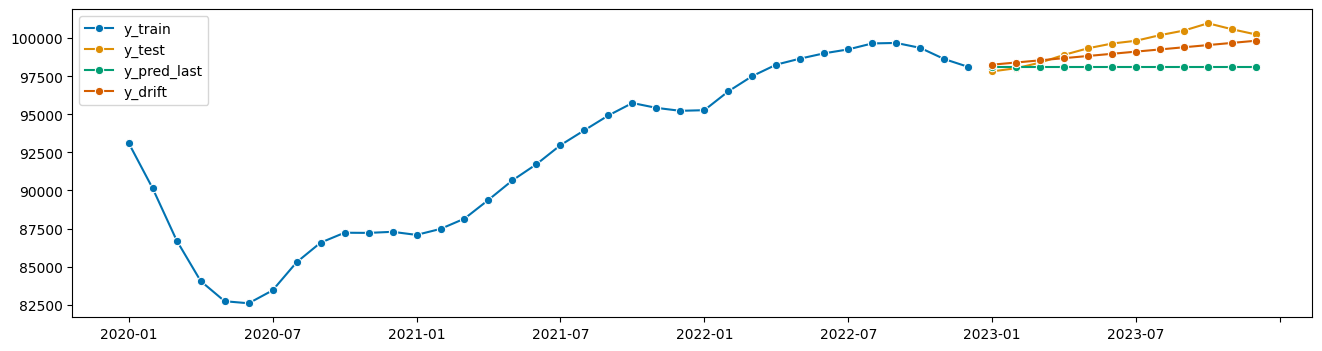

In [116]:
# Naive Forecaster com estratégia 'last'

naive_forecaster_last = NaiveForecaster(strategy="last")
naive_forecaster_last.fit(y_train)
y_last = naive_forecaster_last.predict(fh)

# Naive Forecaster com estratégia 'drift' e sp=12

naive_forecaster_drift = NaiveForecaster(strategy="drift",sp=12)
naive_forecaster_drift.fit(y_train)
y_drift = naive_forecaster_drift.predict(fh)

plot_series(y_train, y_test, y_last,y_drift, labels=["y_train", "y_test", "y_pred_last","y_drift"]);
print('SMAPE para estratégia ''last'': ', MeanAbsolutePercentageError(y_last, y_test))
print('SMAPE para estratégia ''drift'': ', MeanAbsolutePercentageError(y_drift, y_test))

## Previsões com ARIMA

/home/liputer/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/liputer/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/liputer/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/liputer/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/liputer/.local/lib/python3.10/site-packages/statsmodels/base/model

SMAPE usando ARIMA:  MeanAbsolutePercentageError(multilevel=         populacao
2023-01      97825
2023-02      98031
2023-03      98400
2023-04      98910
2023-05      99344
2023-06      99654
2023-07      99838
2023-08     100206
2023-09     100508
2023-10     100985
2023-11     100593
2023-12     100250,
                            multioutput=             populacao
2023-01   99083.452145
2023-02   99916.313868
2023-03  100587.907471
2023-04  101116.129514
2023-05  101551.664063
2023-06  101962.835605
2023-07  102434.590351
2023-08  102937.173611
2023-09  103456.233423
2023-10  103977.552845
2023-11  104498.536206
2023-12  105008.898901)


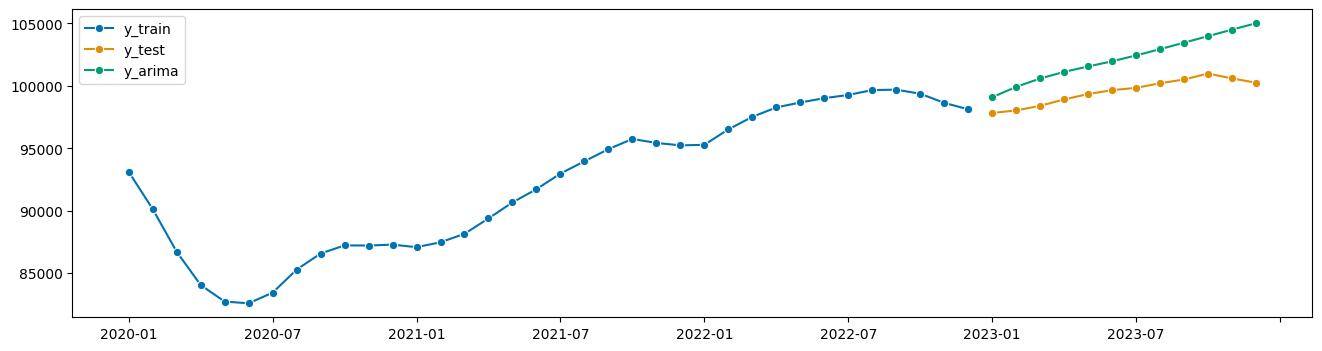

In [48]:
arima_forecasting = AutoARIMA(sp=12)
arima_forecasting.fit(y_train)

# Modelo pode demorar um pouco pois irá testar vários parâmetros.
y_arima = arima_forecasting.predict(fh)

plot_series(y_train, y_test, y_arima, labels=['y_train', 'y_test', 'y_arima'])
print('SMAPE usando ARIMA: ', MeanAbsolutePercentageError(y_arima, y_test))

## Previsões com SARIMA

SMAPE usando SARIMA:  MeanAbsolutePercentageError(multilevel=         populacao
2023-01      97825
2023-02      98031
2023-03      98400
2023-04      98910
2023-05      99344
2023-06      99654
2023-07      99838
2023-08     100206
2023-09     100508
2023-10     100985
2023-11     100593
2023-12     100250,
                            multioutput=            populacao
2023-01  98035.392991
2023-02  97919.453367
2023-03  97881.870637
2023-04  97921.557986
2023-05  98050.672831
2023-06  98132.212229
2023-07  98121.146139
2023-08  98116.636916
2023-09  98095.301996
2023-10  98057.376168
2023-11  98000.218662
2023-12  97953.574179)


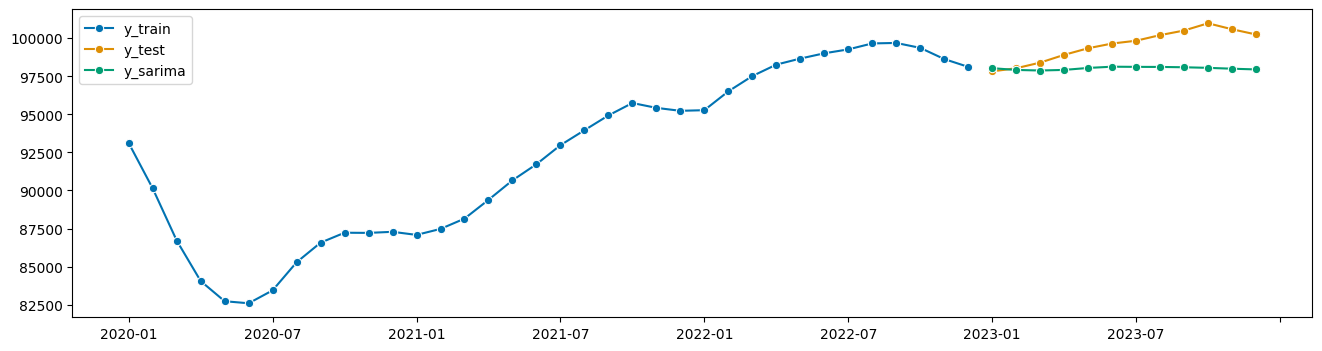

In [46]:
sarima_forecasting = SARIMAX(order=(1, 0, 0), trend="c", seasonal_order=(1, 0, 0, 6))
sarima_forecasting.fit(y_train)

# Modelo pode demorar um pouco pois irá testar vários parâmetros.
y_sarima = sarima_forecasting.predict(fh)

plot_series(y_train, y_test, y_sarima, labels=['y_train', 'y_test', 'y_sarima'])
print('SMAPE usando SARIMA: ', MeanAbsolutePercentageError(y_sarima, y_test))

## Usando o Rolling Forecast Origin
Prevê um mês, compara com o dataset original, "aprende", e prevê o próximo mês.

In [30]:
def pass_month(old_month):
    old_month = str(old_month)
    year = old_month[0:4]
    month = int(old_month[5:])
    if month == 12:
        month = '01'
        year = str(int(year) + 1)
    
    elif month == 9 or month == 10 or month == 11:
        month += 1
        month = str(month)
        
    else:
        month += 1
        month = '0'+ str(month)
    
    new_date = year+'-'+month
    return new_date



In [31]:
teste = df.copy()
train_end = '2023-04'
test_middle = '2023-05'
test_end = '2023-12'
train_data = teste[:train_end]
test_data = teste[test_middle:test_end]

In [34]:
rolling_predictions = df.copy()
for period in test_data.index:
    next_month = pass_month(period)
    train_data = df[:next_month]
    model = SARIMAX(order=(1, 0, 0), trend="c", seasonal_order=(1, 0, 0, 6))
    model.fit(train_data)
    
    pred = model.predict(fh)
    rolling_predictions[period] = pred

/home/liputer/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/liputer/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: >

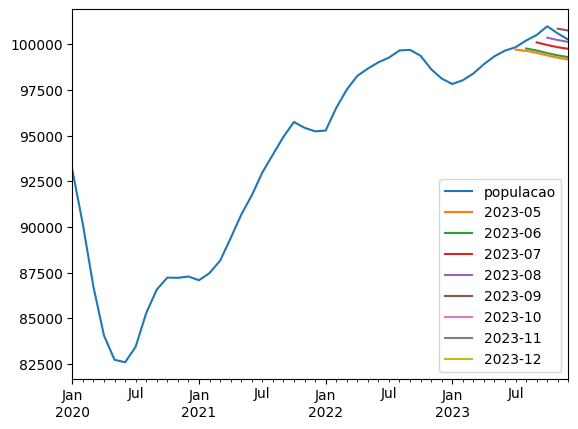

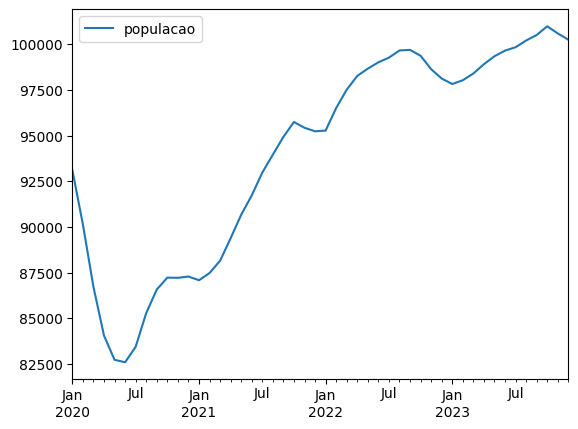

In [45]:
rolling_predictions.plot()
df.plot()